In [153]:
%matplotlib inline
import os
import math 
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import scale, StandardScaler
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from matplotlib.colors import rgb2hex
import warnings
sns.set_style('white')
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 999
warnings.filterwarnings('ignore')

ahba_dir     = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes/AHBA/'
gsea_dir     = '/Users/kanaaax/Desktop/GSEA'
permute_dir  = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes/permutations'
save_fig_dir = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v4'

# wells outside the striatal masks 
wells = [#2371,       # AHBA claustrum, right
         #2379,       # AHBA claustrum, left
         #159226045,  # AHBA striatum -- out of mask
         #160091500   # AHBA septal nuclei, left
         ] 
#housekeeping
drop_strings = ['coords_native', 'donor_names', 'struct_id', 'struct_name', 'top_struct', 'Mean', 'Median', 'PC1', 'PC2','PC3', ]


In [110]:
###########################################
# Read QSM stat maps#
##########################################

df_MNI = pd.read_csv(os.path.join(ahba_dir,'QSM_TSTATS/MNI_NIFTI_VALUES_permute_10K_OCT2.csv'), index_col = 0 )

In [111]:
###########################################
# Read expression values of AHBA database  
###########################################

AHBA = pd.read_csv(os.path.join(ahba_dir, 'ahba_data', 'AHBA_20737.csv'), index_col = 0)

In [112]:
############################################
# Concatenate geneset expression dataframes 
############################################

def return_expression_df(geneset):
    df = pd.read_csv(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset),index_col=0)
    gs = [i for i in df.columns if i not in drop_strings]
    return df, gs 

IRON_H,  GS_IRON_H   = return_expression_df('IRON_HOMEOSTASIS_PCA')
IRON_D,  GS_IRON_D   = return_expression_df('IRON_D_PCA')
IRON_T2, GS_IRON_T2  = return_expression_df('IRON_TRANSPORT2_PCA')
FERRITIN,GS_FERRITIN = return_expression_df('FERRITIN_PCA')

genesets = {'IRON_H'  : GS_IRON_H,'IRON_D'  : GS_IRON_D,'IRON_T2' : GS_IRON_T2,'FERRITIN': GS_FERRITIN}

def concat_dfs(measure):
    df  = pd.DataFrame(index = IRON_H.index, columns = ['IRON', 'IRON_D', 'IRON_T2', 'FERRITIN', 'top_struct', 'struct'])
    xval = 1
    df['top_struct']        = IRON_H.top_struct
    df['struct']            = IRON_H.struct_name
    df['IRON_H']            = IRON_H[measure] * xval
    df['IRON_D']            = IRON_D[measure]
    df['IRON_T2']           = IRON_T2[measure] * xval
    df['FERRITIN']          = FERRITIN[measure] * xval    
    df['FERRITIN']          = FERRITIN[measure] * xval    
    dfc = pd.concat([df_MNI, df], axis = 1)
    return dfc

df_PC1   = concat_dfs('RC1')
df_MU    = concat_dfs('Mean')
df_MD    = concat_dfs('Median')

dfs = {'df_PC1': df_PC1, 'df_MU':df_MU, 'df_MD':df_MD}

In [113]:
GENES = AHBA.columns[:-28]


nucleus = ['STR3_MOTOR_tstat_CP_1mm']

df_chi  = df_MNI.drop([i for i in df_MNI.columns if i not in ['STR_tstat_CP_1mm']],axis=1)
df_chi  = pd.DataFrame(dfs["df_MU"][nucleus].drop(wells,axis=0).dropna()).sort_index(ascending=True)
df_chi.to_csv("/Users/kanaaax/Desktop/chi.csv")
df_chi.head()

,STR3_MOTOR_tstat_CP_1mm
780,0.866077
788,1.242846
827,1.179034
933,1.742089
941,1.334966


In [114]:
AHBAx = AHBA.drop([well for well in AHBA.index if well not in df_chi.index])
AHBAx = AHBAx.drop(AHBAx.columns[-28:],axis=1).sort_index(ascending=True)
AHBAx.to_csv("/Users/kanaaax/Desktop/AHBAx.csv")


In [115]:
AHBAx.head()

,61E3.4,A1BG,A1CF,A26C1B,A2BP1,A2LD1,A2M,A2ML1,A3GALT2P,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL1,AADACL2,AADACL3,AADACL4,AADAT,AAED1,AAGAB,AAK1,AAMP,AANAT,AARD,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB10,ABCB11,ABCB4,ABCB5,ABCB6,ABCB7,ABCB8,ABCB9,ABCC1,ABCC10,ABCC11,ABCC12,ABCC13,ABCC2,ABCC3,ABCC4,ABCC5,ABCC6,ABCC8,ABCC9,ABCD1,ABCD2,ABCD3,ABCD4,ABCE1,ABCF1,ABCF2,ABCF3,ABCG1,ABCG2,ABCG4,ABCG5,ABCG8,ABHD1,ABHD10,ABHD11,ABHD12,ABHD12B,ABHD13,ABHD14A,ABHD14B,ABHD15,ABHD2,ABHD3,ABHD4,ABHD5,ABHD6,ABHD8,ABI1,ABI2,ABI3,ABI3BP,ABL1,ABL2,ABLIM1,ABLIM2,ABLIM3,ABO,ABP1,ABR,ABRA,ABT1,ABTB1,ABTB2,AC002351.1,AC002472.1,AC002472.8,AC002472.9,AC002511.1,AC002563.2,AC003999.1,AC004053.1,AC004080.12,AC004241.1,AC004381.2,AC004409.1,AC004690.2,AC004790.2,AC004797.1,AC004863.6,AC004980.7,AC005014.1,AC005041.9,AC005077.3,AC005152.2,AC005277.1,AC005301.1,AC005358.1,AC005393.1,AC005488.13,AC005512.1,AC005551.1,AC005829.1,AC005840.2,AC005921.3,AC005962.2,AC006014.8,AC006273.1,AC006276.1,AC006517.3,AC007276.5,AC007364.1,AC007405.8,AC007510.1,AC007601.1,AC007688.2,AC007743.1,AC007952.2,AC008026.2,AC008073.1,AC008073.2,AC008074.2,AC008132.4,AC008429.1,AC008449.1,AC008537.3,AC008687.3,AC008735.3,AC008806.1,AC008875.1,AC008969.2,AC009086.2,AC009093.1,AC009107.3,AC009123.1,AC009139.1,AC009163.1,AC009171.1,AC009236.1,AC009365.1,AC009509.1,AC009532.1,AC010087.3,AC010203.2,AC010325.3,AC010332.1,AC010336.2,AC010422.1,AC010442.2,AC010606.4,AC010624.2,AC010645.1,AC010896.1,AC010974.2,AC010980.2,AC010982.1,AC011346.1,AC011427.1,AC011443.1,AC011472.2,AC011479.2,AC011498.2,AC011498.3,AC011500.2,AC011511.1,AC011530.1,AC012100.1,AC012435.1,AC012621.2,AC012652.1,AC013271.3,AC013283.1,AC013356.1,AC013356.3,AC013400.2,AC013402.2,AC013553.1,AC013553.2,AC015871.2,AC015936.3,AC016525.1,AC016629.3,AC016683.6,AC016747.3,AC016757.1,AC017096.1,AC017099.3,AC018682.6,AC018755.8,AC018865.8,AC019171.4,AC020663.1,AC021054.1,AC021148.2,AC021534.2,AC021850.1,AC021860.1,AC022075.1,AC022098.1,AC022098.3,AC022100.1,AC022311.1,AC022498.2,AC022596.6,AC022748.1,AC023024.1,AC023055.2,AC023510.2,AC023830.2,AC024270.1,AC024560.3,AC024575.2,AC024575.3,AC024940.3,AC025627.16,AC025647.1,AC026369.2,AC027323.1,AC034193.5,AC034199.2,AC034236.3,AC044839.2,AC055839.1,AC058791.2,AC062028.1,AC063965.2,AC063977.1,AC066593.1,AC068020.3,AC068057.2,AC068181.1,AC068353.1,AC068385.1,AC068491.1,AC068580.3,AC068658.1,AC068989.2,AC069029.1,AC069146.2,AC069154.2,AC069234.1,AC069525.1,AC073043.2,AC073135.1,AC073343.8,AC073346.1,AC073548.1,AC073869.20,AC074286.1,AC078802.1,AC078847.1,AC078937.4,AC079061.1,AC079341.1,AC079776.2,AC079953.2,AC084018.1,AC084125.1,AC084209.1,AC084851.1,AC087309.1,AC087392.3,AC087645.1,AC087742.2,AC090099.4,AC090360.1,AC090844.1,AC091152.2,AC091565.3,AC091878.1,AC092070.4,AC092070.5,AC092143.3,AC092324.1,AC092327.1,AC092329.2,AC092384.2,AC092436.3,AC092490.2,AC093063.1,AC093283.3,AC093310.1,AC093726.2,AC093734.11,AC093838.4,AC093849.1,AC094086.1,AC096655.2,AC097067.1,AC098591.2,AC098799.1,AC099524.1,AC099759.1,AC099797.1,AC100756.1,AC100775.1,AC100793.2,AC100793.3,AC100803.1,AC103540.1,AC103965.1,AC104665.1,AC104819.1,AC105206.1,AC105337.1,AC105391.2,AC106037.2,AC106739.1,AC106818.2,AC107212.1,AC107883.1,AC107983.3,AC108134.5,AC108938.1,AC109486.1,AC110619.2,AC110754.1,AC110760.2,AC110814.1,AC112641.2,AC113191.1,AC114273.1,AC114947.2,AC115090.1,AC116165.2,AC116334.1,AC116655.15,AC117392.3,AC117460.2,AC120024.1,AC120045.5,AC120114.2,AC125232.1,AC126544.1,AC128683.1,AC130416.1,AC130416.2,AC130454.1,AC130686.2,AC131238.1,AC132186.2,AC132812.1,AC133485.2,AC134312.1,AC134982.1,AC135050.2,AC135178.1,AC135457.2,AC135457.3,AC135592.2,AC135731.1,AC135983.8,AC135995.5,AC136443.1,AC136604.1,AC136632.1,AC138028.2,AC138472.2,AC138894.3,AC138951.4,AC139099.1,AC139768.2,AC140481.7,AC141586.5,AC144830.1,AC145098.2,AC147055.1,AC152006.2,AC174470.1,AC183087.2,AC217771.1,AC217773.2,AC226150.1,AC2337

In [182]:
pls = PLSRegression(n_components=3)
pls?

Type:        PLSRegression
String form: PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)
File:        ~/anaconda2/lib/python2.7/site-packages/sklearn/cross_decomposition/pls_.py
Docstring:  
PLS regression

PLSRegression implements the PLS 2 blocks regression known as PLS2 or PLS1
in case of one dimensional response.
This class inherits from _PLS with mode="A", deflation_mode="regression",
norm_y_weights=False and algorithm="nipals".

Read more in the :ref:`User Guide <cross_decomposition>`.

Parameters
----------
n_components : int, (default 2)
    Number of components to keep.

scale : boolean, (default True)
    whether to scale the data

max_iter : an integer, (default 500)
    the maximum number of iterations of the NIPALS inner loop (used
    only if algorithm="nipals")

tol : non-negative real
    Tolerance used in the iterative algorithm default 1e-06.

copy : boolean, default True
    Whether the deflation should be done on a copy. Let the default


In [117]:
fit = pls.fit(AHBAx,df_chi)

In [118]:
fit.x_scores_[:,0]

array([-4.31361430e+01, -3.71855729e+01, -7.10084939e+01, -2.70337412e+01,
       -1.97253599e+01, -6.03568250e+01, -2.43434092e+01, -1.02724916e+00,
       -1.94566883e+01, -8.07547949e+00,  7.52749438e+01,  5.46651208e+01,
        5.79315162e+01,  8.23733632e+01,  3.67023156e+01,  1.46156276e+01,
       -3.05868623e+01, -6.11612465e+01,  6.06891584e+00, -5.61612067e+00,
       -1.65635546e-01, -1.46002740e-01, -1.58894834e+01,  5.47729159e+00,
        5.27187418e+01,  2.03596304e+01,  8.30556813e+00,  4.68904792e+01,
       -2.46186628e+01, -4.96365990e+01,  3.02741420e+01, -6.78789594e+01,
       -4.91467110e+01, -2.51840403e+01,  3.69422004e+01,  1.00356667e+02,
        5.12058157e+01, -3.47396749e+01, -1.73175926e+01, -1.72769528e+01,
        7.24855685e-01, -2.57606785e+01, -1.01482828e+02, -8.42448621e+01,
       -8.94133330e+01,  1.27924948e+01,  3.44306397e+01, -7.72363054e+00,
       -1.64498028e+01, -1.04971983e+01,  4.01542401e+01, -4.48269588e+00,
       -2.30676073e+01, -

(0.551071103745039, 3.461745230244622e-06)


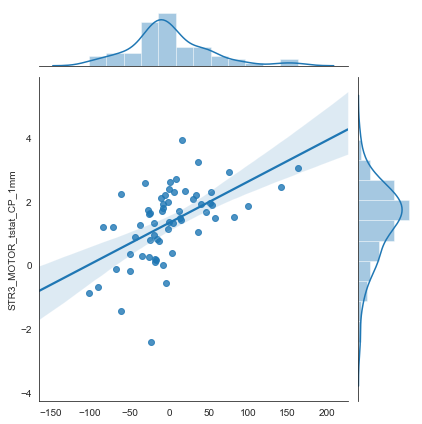

In [160]:
import seaborn as sns 
print pearsonr(fit.x_scores_[:,0], df_chi.STR3_MOTOR_tstat_CP_1mm)
sns.jointplot(fit.x_scores_[:,0] , df_chi.STR3_MOTOR_tstat_CP_1mm, kind='reg', 
             annot_kws=dict(stat="r"))

In [173]:
from scipy import stats
df_pls = pd.DataFrame(index=AHBAx.columns, columns=['PLSweights'])
df_pls["PLSweights"] = scale(fit.x_weights_)

In [171]:
stats.zscore(fit.x_weights_)

array([[ 2.26737933, -1.65368307, -0.30045158],
       [ 0.05542435, -0.04449327,  0.43974115],
       [-0.41445081, -1.56772513, -0.73790462],
       ...,
       [ 1.32946948, -1.12249794,  0.25038703],
       [ 1.37993446, -0.40893257,  0.39470609],
       [-0.44666512, -1.17384853,  0.46626933]])

In [180]:
df_pls.sort_values('PLSweights', ascending=0)
df_pls.index.name = "Gene"
df_pls.to_csv('/Users/kanaaax/Desktop/pls.rnk', sep='\t')